# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

C:\Users\afina\AppData\Local\Temp\ipykernel_8760\1106472720.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

Загружаем в датафрейм df из данные из файла bank_fin.csv. Делаем предварительный просмотр содержимого df. 

In [4]:
# Копируем содержимое базы, которую собираемся иследовать, из файла bank_fin.csv в датафрейм df
df = pd.read_csv('bank_fin.csv', sep = ';')

In [5]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


Мы видим, что в нашем датасете 11 162 записи и каждая запись состоит из 17 столбцов (факторов).  целом их можно разделить на несколько групп:

**Данные о клиентах банка:**
- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**
- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).
  
**Прочие признаки:**
- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).
  
Наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать.
  
Посмотрим в каких форматах содержатся записи в столбцах (признаках).

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Посмотрим на наличие пропусков в датафрейме.

In [7]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Мы видим, что пропуски у нас содержатся в 25 записях в информации о признаке "balance". Но так ли это на самом деле ?

### Задание 2

Посмотрим уникальные значения в каждом признаке.

In [8]:
column_list = df.columns.tolist()

for col in column_list:
   print(col)
   print(df[col].unique())
   print('\n\n')

age
[59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89]



job
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']



marital
['married' 'single' 'divorced']



education
['secondary' 'tertiary' 'primary' 'unknown']



default
['no' 'yes']



balance
[' 2 343,00 $ ' ' 45,00 $ ' ' 1 270,00 $ ' ... ' 1 594,00 $ '
 ' 2 593,00 $ ' '-134,00 $ ']



housing
['yes' 'no']



loan
['no' 'yes']



contact
['unknown' 'cellular' 'telephone']



day
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31]



month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']



duration
[1042 1467 1389 ... 1504  818 1812]



campaign
[ 1  2  3  4  6  5  8 11  9 10 15 12 14  

В признаках 'job', 'education', 'contact', 'poutcome' - пропуски обозначены записью 'unknown'.

### Задание 3

Мы видим, что признак 'balance' имеет тип 'object' - запись в виде текста, при чем по формату "число с двумя записями после точки + пробел + знак $". Выделим число из записи и преобразуем таким образом записи нашего признака  в формат 'float'.

In [9]:
# Для удобства создадим копию нашего датасета.
df_1 = df.copy()

In [10]:
# Функция balance_search берет текст и удаляет в нем пробелы, знак '$', меняет ',' на  '.' и полученный текст преобразует в формат Float
def balance_search(Text):
    #if not Text:
        #return None
    # Проверка, является ли Text строкой
    if isinstance(Text, str):
        # Удаление символов и замена
        cleaned_Text = (Text.replace(' ', '').replace('$', '').replace(',', '.'))
        return float(cleaned_Text)
    else:
        return None
    
 
# Проводим преобразование столбца 'balance', используя функцию balance_search
df_1['balance'] = df_1['balance'].apply(balance_search)

# Распечатаем средее значение элементов столбца
balance_mean = round(df_1['balance'].mean(),3)
print(balance_mean)

1529.129


### Задание 4

Обработаем пропуски признака 'balance', заменив их на медиану значений этого признака. 

In [11]:
df_1['balance'] = df_1['balance'].apply(lambda x: df_1['balance'].median() if pd.isnull(x) else x)

# Посмотрим, как изменится среднее значение признака 'balance'

balance_mean2 = round(df_1['balance'].mean(),3)
print(balance_mean2)

1526.936


### Задание 5

Обработаем пропуски в категориальных признаках 'job' и 'education', заменив их на модальные значения.

In [12]:
# составляем список уникальных значений признака 'job' - job_uniq
job_uniq = df_1['job'].unique()

# переменная MAX_job будет у нас служить для поиска наиболее часто встрачающегося значения признака 'job'
# Для начала присвои переменной MAX_job, название первой записи в списке job_uniq
MAX_job = df_1['job'][0]

# Обычный цикл для поиска максимального значения в списке
for i in job_uniq:
    if df_1['job'][df_1['job'] == i].shape[0] > df_1['job'][df_1['job'] == MAX_job].shape[0]:
        MAX_job = i
    #print(f"Значение {i} встречается {df_1['job'][df_1['job'] == i].shape[0]} раз")

print(f"Наиболее часто встречающиеся значение признака 'job' - {MAX_job}")

Наиболее часто встречающиеся значение признака 'job' - management


In [13]:
# Аналогично проводим операции с значениями признака 'education'
educt_uniq = df_1['education'].unique()

MAX_educt = df_1['education'][0]

for i in educt_uniq:
    if df_1['education'][df_1['education'] == i].shape[0] > df_1['education'][df_1['education'] == MAX_educt].shape[0]:
        MAX_educt = i
    #print(f"Значение {i} встречается {df_1['education'][df_1['education'] == i].shape[0]} раз")

print(f"Наиболее часто встречающиеся значение признака 'education' - {MAX_educt}")

Наиболее часто встречающиеся значение признака 'education' - secondary


Проведем замену пропусков значений 'unknown' в признаках 'job' и 'education' на их модальные значения 'management'и 'secondary' соответственно.

In [14]:
df_1['job'].replace(['unknown'], MAX_job, inplace = True)
df_1['education'].replace(['unknown'], MAX_educt, inplace = True)

In [15]:
# Найдем среднее значение по признаку 'balance' у клиентов с модальными значениями признаков 'job' и 'education' - 'management'и 'secondary' соответственно

Balance_max_job_educat = df_1[df_1['job']==MAX_job][df_1['education']==MAX_educt]

print(round(Balance_max_job_educat['balance'].mean(),3))

1598.883


### Задание 6

Найдем выбросы значений признака 'balance' по методу Тьюки и удалим из датафрейма записи, у которых значение признака 'balance' попадает в эти выбросы.

In [16]:
# Вычисление квартилей
Q1 = df_1['balance'].quantile(0.25)
Q3 = df_1['balance'].quantile(0.75)

# Вычисление IQR
IQR = Q3 - Q1

# Расчет границ
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница по методу Тьюки  - {round(lower_bound)}")
print(f"Верхняя граница по методу Тьюки - {round(upper_bound)}")

Нижняя граница по методу Тьюки  - -2241
Верхняя граница по методу Тьюки - 4063


In [17]:
# Создадим новый датасет df_2 из датасета df_1, удалив записи с выбросами признака 'balance'
df_2 = df_1[df_1['balance'] >= lower_bound][df_1['balance'] <= upper_bound]

# Посмотрим на датасет df_2
df_2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


В обработанном датасете стало  10 105 записей, вместо 11 162, как это было первоначально.

## Часть 2:  Разведывательный анализ

### Задание 1

Давайте изучим распределение целевой переменной 'deposit': есть ли несбалансированность классов?

Переменная 'deposit' бинарная и она принимает два уникальных значения 'yes' или 'no'. Посмотрим на сбалансированность значений этой переменной путем построения, соответствующей диаграммы. 

<Axes: xlabel='deposit'>

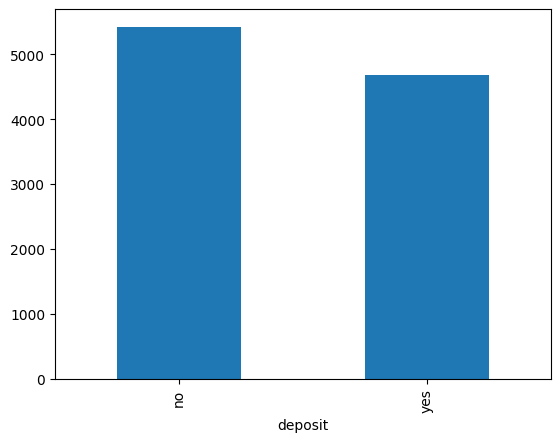

In [18]:
types = df_2['deposit'].value_counts(normalize=False)

types.plot(kind='bar', stacked='True')

Из диаграммы видно, переменная 'deposit' относительно сбалансирована по значениям 'yes' и 'no'.

In [19]:
print(f"Общее число клиентов, открывших в банке депозит - {df_2[df_2['deposit'] == 'yes'].shape[0]}, что составлячет {round(df_2[df_2['deposit'] == 'yes'].shape[0]/df_2.shape[0],2)}% от опрошенных клиентов")

Общее число клиентов, открывших в банке депозит - 4681, что составлячет 0.46% от опрошенных клиентов


### Задания 2 и 3

Рассчитаем описательные статистики для некоторых колличественных переменных.

In [20]:
# Максимальный возраст среди клиентов банка

print(f"Максимальный возраст клиентов банка - {df_2['age'].max()} лет.")

Максимальный возраст клиентов банка - 95 лет.


In [21]:
# Минимальная продолжительность разговора c клиентом банка

print(f"Минимальная продолжительность разговора c клиентом банка составила {df_2['duration'].min()} секунды.")

Минимальная продолжительность разговора c клиентом банка составила 2 секунды.


### Задания 4 и 5

In [22]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

Рассчитаем описательные статистики для некоторых категориальных переменных.

In [23]:
# Сколько было месяцев, в которых проводилась маркетинговая кампания

print(f"Рекламная компания проводилась в {len(df_2['month'].unique())} месяцах")

Рекламная компания проводилась в 12 месяцах


In [24]:
# Сколько сфер занятости представлено среди клиентов банка

print(f"Среди клиентов банка представлено {len(df_2['job'].unique())} сфер занятости")

Среди клиентов банка представлено 11 сфер занятости


### Задание 6

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

У нас есть признак 'poutcome' (результат прошлой маркетинговой кампании), который принимает четыре значения;  'unknown', 'other', 'failure', 'success'

Найдем значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач, т.е. при каком статусе(значении) 'poutcome' (из четырех) у нас получилась самая большая разница между случаями, при которых открывался депозит и случаями при которых депозит не открывался.

<Axes: xlabel='poutcome'>

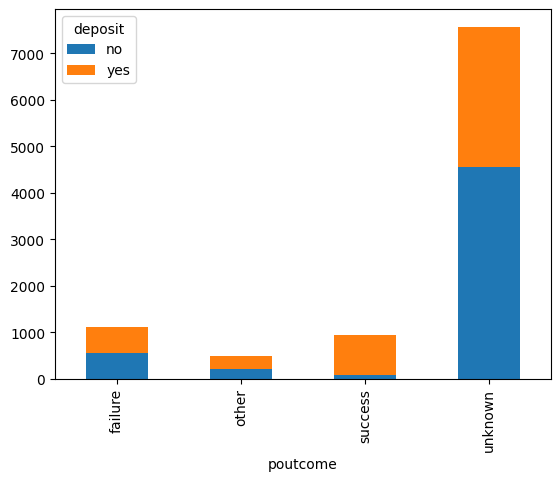

In [25]:
# Построим график по всем четырем значениям, принимаемых признаком 'poutcome' в разрезе групп , открывших и не открывших депозит.

Poutcome_list = df_2['poutcome'].unique()

types = df_2.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()

types.plot(kind='bar', stacked='True')

Больше всего клиентов, открывших депозит, находятся в группе 'unknown' (желтая полоска), но в этой же группе еще больше клиентов не открывших депозит, т.е. в целом по этой группе результат компании отрицательный. 

В группе 'success' из трех последних групп самая длинная желтая полоска, при тоненькой синей полоске.

Вывод из диаграммы: искомое значение признака 'poutcome'(результат работы прошлой компании ) - это 'success'(успех). Клиенты давшие успешные результаты по результатам прошлой компании, по результатам новой компании дали самый лучший результат, заключающийся в превышении колличества клиентов открывших депозит над коиентами, не открывшими депозит.

In [26]:
# Теперь получим этот вывод путем расчетов.
# Создадим пустой словарь, в котором значению признака 'poutcome'(ключу) будет соответствовать значение - разности между клиентами открывшими и клиентами не открывшими депозит
Poutcome_dict = {}

# Запустим цикл по значениям признака 'poutcome'
for i in Poutcome_list:
    # Для каждого значения признака 'poutcome' рассчитывавем значение K - разности между клиентами открывшими и клиентами не открывшими депозит.
    K = df_2[df_2['poutcome'] == i][df_2['deposit'] == 'yes'].shape[0] - df_2[df_2['poutcome'] == i][df_2['deposit'] == 'no'].shape[0]
    # Заносим в словарь новую запись 
    Poutcome_dict[i] = K
    #print(f"В признаке {i} разница между успехами и неудачами составляет - {K} случаев")

#print(Poutcome_dict)

# Найдем в нашем словаре ключ записи  с самым большим значением 
max_key = max(Poutcome_dict, key = Poutcome_dict.get)

print(f"В признаке poutcome при значении статуса {max_key} разница между успехами и неудачами составляет - {Poutcome_dict[max_key]} случаев")

В признаке poutcome при значении статуса success разница между успехами и неудачами составляет - 777 случаев


### Задание 7

Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

Рассчитаем, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. 

<Axes: xlabel='month'>

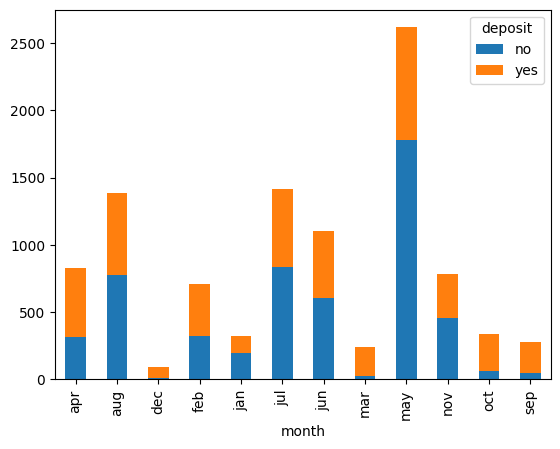

In [27]:
# Попробуем определить результат с помощью диаграммы.

types = df_2.groupby("month")['deposit'].value_counts(normalize=False).unstack()

types.plot(kind='bar', stacked='True')

На диаграмме мы видим, что самый неудачный у нас месяц это май (самое большая в процентном соотношении число клиентов не открывших депозит, к общему числу клиентов.)

In [28]:
# Подтвердим наш вывод числовыми расчетами.

# Создадим список уникальных значений признака 'month'
Month_list = df_2['month'].unique()

# Создадим пустой словарь, в котором значению признака 'month'(ключу) будет соответствовать значение - соотношение клиентов не открывших депозит к общему числу клиентов.
Month_success_proc_dict = {}

for i in Month_list:
    K = round (df_2[df_2['month'] == i][df_2['deposit'] == 'no'].shape[0]/df_2[df_2['month'] == i].shape[0],2)
    Month_success_proc_dict[i] = K
    


max_key = max(Month_success_proc_dict, key = Month_success_proc_dict.get)

print(f"В месяце {max_key} самый большой процент неудач при взаимодействии в текущей маркетинговой кампании - {Month_success_proc_dict[max_key]} %")

В месяце may самый большой процент неудач при взаимодействии в текущей маркетинговой кампании - 0.68 %


### Задание 8

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создадим новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:
- '<30';
- '30-40';
- '40-50';
- '50-60';
- '60+'.
  
Выберем из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

In [29]:
# Создадим словарь, где ключем будет название возрастной группы, а значением соотношение клиентов открывших к клиентам не открывшим депозит.

Age_group = {"<30": round(df_2[df_2['age']<30][df_2['deposit'] == 'yes'].shape[0]/df_2[df_2['age']<30][df_2['deposit'] == 'no'].shape[0],2),
                       
             "30-40":round(df_2[df_2['age']>=30][df_2['age']<40][df_2['deposit'] == 'yes'].shape[0]/df_2[df_2['age']>=30][df_2['age']<40][df_2['deposit'] == 'no'].shape[0],2),
             
             "40-50":round(df_2[df_2['age']>=40][df_2['age']<50][df_2['deposit'] == 'yes'].shape[0]/df_2[df_2['age']>=40][df_2['age']<50][df_2['deposit'] == 'no'].shape[0],2),
             
             "50-60":round(df_2[df_2['age']>=50][df_2['age']<60][df_2['deposit'] == 'yes'].shape[0]/df_2[df_2['age']>=50][df_2['age']<60][df_2['deposit'] == 'no'].shape[0],2),
             
             ">60": round(df_2[df_2['age']>=60][df_2['deposit'] == 'yes'].shape[0]/df_2[df_2['age']>=60][df_2['deposit'] == 'no'].shape[0],2)}

Age_group

{'<30': 1.45, '30-40': 0.76, '40-50': 0.65, '50-60': 0.68, '>60': 3.16}

Мы видим, что лучшие соотношения у клиентов группы "60+" и группы до "30". Построим диаграмму, чтоб визуализировать этот вывод.

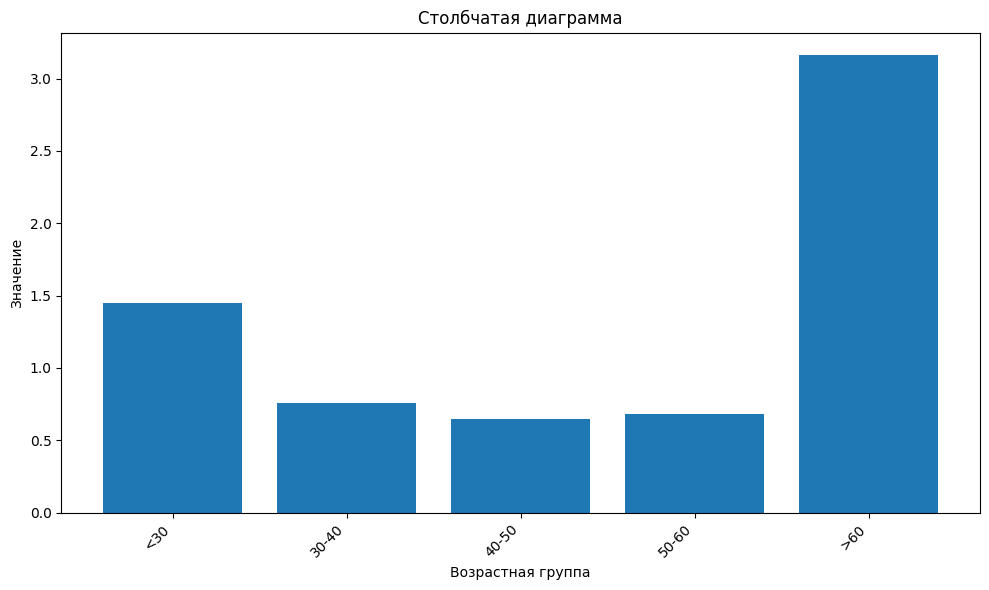

In [30]:
# Создание данных для диаграммы
keys = list(Age_group.keys())
values = list(Age_group.values())

# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.bar(keys, values)

# Добавление надписей и оформление
plt.title('Столбчатая диаграмма')
plt.xlabel('Возрастная группа')
plt.ylabel('Значение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Для анализа нам целесообразно будет преобразовать наш признак возраст в порядковую переменную по группам. Для этого передадим метки и закодируем наш признак методом LabelEncoder

In [31]:
# Создадим порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

# создаем новый признак 'age_modif' из признака 'age', разметив его значения по меткам: ,30,40,50,60,9999
df_2['age_modif'] = pd.cut(df_2.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

# Применим метод кодирования по меткам LabelEncoder() и преобразуем значения признака 'age_modif', применив этот метод.
le = LabelEncoder()
df_2['age_modif'] = le.fit_transform(df_2['age_modif'])

# Посмотрим, что у нас получилось
df_2['age_modif'].unique()

array([2, 1, 0, 4, 3])

### Задания 9 и 10

Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

- семейное положение;
- уровень образования;
- сфера занятости.
  
Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Оформим это диаграммой.

In [32]:
# В какой сфере занято наибольшее число клиентов банка ?

List_of_jobs = df_2['job'].unique()

Job_dict = {}

for i in List_of_jobs:
    K = df_2[df_2['job'] == i][df_2['deposit'] == 'yes'].shape[0]
    Job_dict[i] = K



max_key = max(Job_dict, key = Job_dict.get)

print(f"В сфере {max_key} занято наибольшее число клиентов банка - {Job_dict[max_key]} человек")

В сфере management занято наибольшее число клиентов банка - 1135 человек


In [33]:
# При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

List_of_marital = df_2['marital'].unique()

Marital_dict = {}

for i in List_of_marital:
    K = df_2[df_2['marital'] == i][df_2['deposit'] == 'yes'].shape[0]/df_2[df_2['marital'] == i][df_2['deposit'] == 'no'].shape[0]
    Marital_dict[i] = K
    
max_key = max(Marital_dict, key = Marital_dict.get)

print(f"При семейном положении - {max_key} есть наибольшая тенденция открытия депозита, чем отказываться от него")

При семейном положении - single есть наибольшая тенденция открытия депозита, чем отказываться от него


В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению. Представим результаты в виде тепловых карт. Посмотрим, как различаются наиболее популярные группы для открывших депозит и для неоткрывших.

In [34]:
bank1 = df_2[df.deposit == 'yes'][['education','marital','deposit']]
res1 = pd.crosstab(bank1['education'],bank1['marital'])

In [35]:
bank2 = df_2[df.deposit == 'no'][['education','marital','deposit']]
res2 = pd.crosstab(bank2['education'],bank2['marital'])

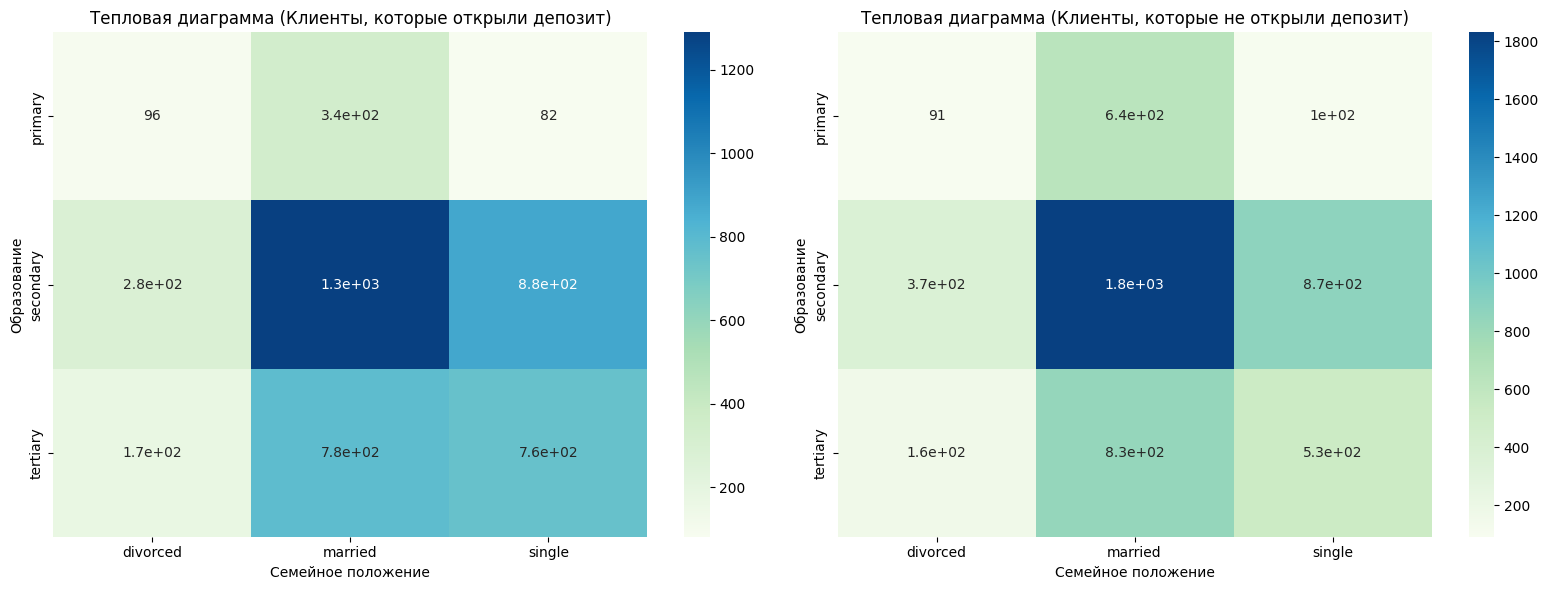

In [36]:
# Создание фигуры и осей
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Построение первой тепловой диаграммы
sns.heatmap(res1, annot=True, cmap='GnBu', ax=ax1)
ax1.set_title('Тепловая диаграмма (Клиенты, которые открыли депозит)')
ax1.set_xlabel('Семейное положение')
ax1.set_ylabel('Образование')

# Построение второй тепловой диаграммы
sns.heatmap(res2, annot=True, cmap='GnBu', ax=ax2)
ax2.set_title('Тепловая диаграмма (Клиенты, которые не открыли депозит)')
ax2.set_xlabel('Семейное положение')
ax2.set_ylabel('Образование')

plt.tight_layout()
plt.show()

И в группе клиентов "не открывших депозит" и "открывших депозит" наиболее многочисленна группа пересечений значений 'secondary'/'married' соответственно признаков 'education'/'marital'.

## Часть 3: преобразование данных

### Задание 1

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек.

Найдем сумму получившихся значений для признака education.

In [37]:
df_2['education'] = LabelEncoder().fit_transform(df_2['education'])

df_2['education']

0        1
1        1
2        1
3        1
4        2
        ..
11157    0
11158    1
11159    1
11160    1
11161    1
Name: education, Length: 10105, dtype: int32

In [38]:
print(f"Сумма получившихся значений признака 'education' - {df_2['education'].sum()}")

Сумма получившихся значений признака 'education' - 11995


### Задания 2 и 3

In [39]:
# преобразуйте бинарные переменные в представление из нулей и единиц

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [40]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_2['deposit'] = lab_enc.fit_transform(df_2['deposit'])

In [41]:
# Вычислим стандартное отклонение по преобразованной в корректный вид целевой переменной deposit.

print(f"Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit - {round(df_2['deposit'].std(),3)}")

Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit - 0.499


Сделаем то же самое для других бинарных переменных, которых у нас три:

- 'default';
- 'housing';
- 'loan'.
  
Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [42]:
list_of_binars = ('default','housing', 'loan')

for col in list_of_binars:
    if col in df_2.columns:
        df_2[col] = lab_enc.fit_transform(df_2[col])

In [43]:
# Вычислим среднее арифметическое для каждого из преобразованных признаков и сложим эти три результата

print(round(df_2['default'].mean() + df_2['housing'].mean() + df_2['loan'].mean(),3))

0.635


### Задание 4

In [44]:
# создайте дамми-переменные

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

- 'job';
- 'marital';
- 'contact';
- 'month';
- 'poutcome'.

Создайте для них dummy-переменные и добавьте их в набор данных.

In [45]:
df_3 = df_2.copy()

dumm_cols = ['job', 'marital', 'contact', 'month', 'poutcome']

df_dumm = pd.get_dummies(df_3[dumm_cols])
df_3 = pd.concat([df_3, df_dumm], axis = 1)

df_3

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,...,False,False,False,False,False,False,False,False,False,True
11158,39,services,married,1,0,733.0,0,0,unknown,16,...,True,False,False,False,False,False,False,False,False,True
11159,32,technician,single,1,0,29.0,0,0,cellular,19,...,False,False,False,False,False,False,False,False,False,True
11160,43,technician,married,1,0,0.0,0,1,cellular,8,...,False,False,True,False,False,False,True,False,False,False


### Задания 5 и 6

Построим корреляционную матрицу признаков датасета и оценим данные на предмет наличия мультиколлинеарности.

Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Дополните корреляционную матрицу тепловой картой, отражающей результат. 

В дополнение к тепловой карте построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

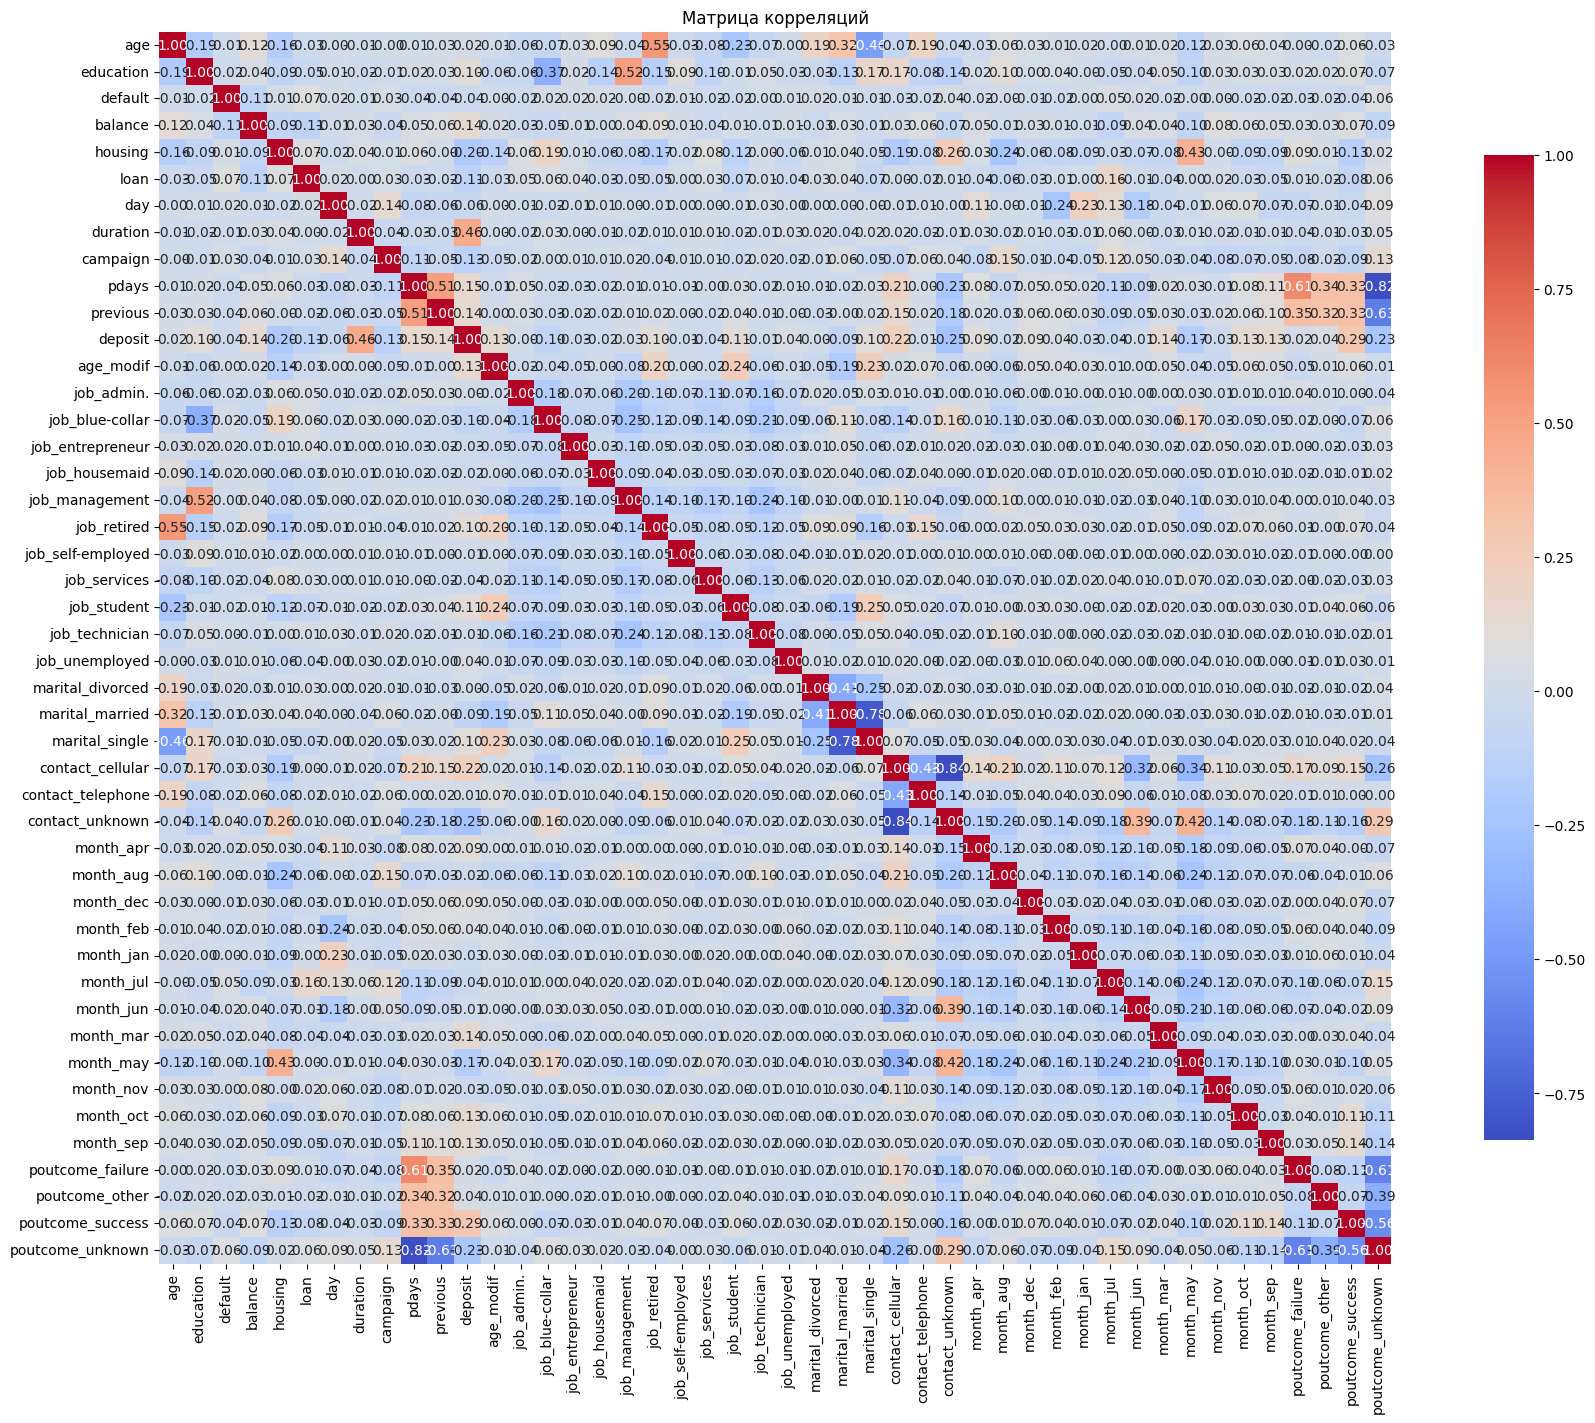

In [46]:
# Создадим копию df_4 из вышеполученного датафрейма df_3 за вычетом признаков 'job', 'marital', 'contact', 'month', 'poutcome' из которых мы создали dummy-переменные.
df_4 = df_3.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis = 1)


# Вычисляем матрицу корреляций
corr = df_4.corr()

# Создаем тепловую карту
plt.figure(figsize=(24, 16))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций')
plt.show()

Посмотрим между какими парами признаков в джатасете есть:
- $- 0.3 ≤ |r| < 0.5$ - умеренная связь
- $0.5 ≤ |r| < 0.7$ - заметная (средняя) связь
- $0.7 ≤ |r| < 0.9$ - высокая связь
- $0.9 ≤ |r| ≤ 1$ - очень высокая (сильная) связь

In [47]:
# Находим пары признаков со значениями корреляции по модулю больше 0.9
high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i,j]) > 0.9:
            high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))

if len(high_corr_pairs) == 0:
    print("В нашей корелляционной матрице нет признаков с сильной (высокой) связью - коэффициентом корреляции блольшим по модулю 0.9")
else:
    # Выводим найденные пары
    for pair in high_corr_pairs:
        print(f"Признаки с очень сильной связью: {pair[0]} и {pair[1]}, коэффициент корреляции: {pair[2]:.2f}")

В нашей корелляционной матрице нет признаков с сильной (высокой) связью - коэффициентом корреляции блольшим по модулю 0.9


In [48]:
# Находим пары признаков со значениями корреляции по модулю большим 0.7 и меньшим 0.9
middle_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i,j])<= 0.9 and abs(corr.iloc[i,j])> 0.7 :
            middle_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))

if len(middle_corr_pairs) == 0:
    print("В нашей корелляционной матрице нет признаков с высокой связью - коэффициентом корреляции блольшим по модулю 0.7 и меньшим 0.9")
else:
    # Выводим найденные пары
    for pair in middle_corr_pairs:
        print(f"Признаки с высокой связью: {pair[0]} и {pair[1]}, коэффициент корреляции: {pair[2]:.2f}")

Признаки с высокой связью: pdays и poutcome_unknown, коэффициент корреляции: -0.82
Признаки с высокой связью: marital_married и marital_single, коэффициент корреляции: -0.78
Признаки с высокой связью: contact_cellular и contact_unknown, коэффициент корреляции: -0.84


In [49]:
# Находим пары признаков со значениями корреляции по модулю большим 0.5 и меньшим 0.7
middlest_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i,j])<= 0.7 and abs(corr.iloc[i,j])> 0.5 :
            middlest_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))

if len(middlest_corr_pairs) == 0:
    print("В нашей корелляционной матрице нет признаков с заметной (средней) связью - коэффициентом корреляции блольшим по модулю 0.7 и меньшим 0.9")
else:
    # Выводим найденные пары
    for pair in middlest_corr_pairs:
        print(f"Признаки с заметной (средней) связью: {pair[0]} и {pair[1]}, коэффициент корреляции: {pair[2]:.2f}")

Признаки с заметной (средней) связью: age и job_retired, коэффициент корреляции: 0.55
Признаки с заметной (средней) связью: education и job_management, коэффициент корреляции: 0.52
Признаки с заметной (средней) связью: pdays и previous, коэффициент корреляции: 0.51
Признаки с заметной (средней) связью: pdays и poutcome_failure, коэффициент корреляции: 0.61
Признаки с заметной (средней) связью: previous и poutcome_unknown, коэффициент корреляции: -0.63
Признаки с заметной (средней) связью: poutcome_failure и poutcome_unknown, коэффициент корреляции: -0.61
Признаки с заметной (средней) связью: poutcome_success и poutcome_unknown, коэффициент корреляции: -0.56


In [50]:
# Находим пары признаков со значениями корреляции по модулю большим 0.3 и меньшим 0.5
measured_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i,j])<= 0.5 and abs(corr.iloc[i,j])> 0.3 :
            measured_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))

if len(measured_corr_pairs) == 0:
    print("В нашей корелляционной матрице нет признаков с умеренной связью - коэффициентом корреляции блольшим по модулю 0.7 и меньшим 0.9")
else:
    # Выводим найденные пары
    for pair in measured_corr_pairs:
        print(f"Признаки с умеренной связью: {pair[0]} и {pair[1]}, коэффициент корреляции: {pair[2]:.2f}")

Признаки с умеренной связью: age и marital_married, коэффициент корреляции: 0.32
Признаки с умеренной связью: age и marital_single, коэффициент корреляции: -0.46
Признаки с умеренной связью: education и job_blue-collar, коэффициент корреляции: -0.37
Признаки с умеренной связью: housing и month_may, коэффициент корреляции: 0.43
Признаки с умеренной связью: duration и deposit, коэффициент корреляции: 0.46
Признаки с умеренной связью: pdays и poutcome_other, коэффициент корреляции: 0.34
Признаки с умеренной связью: pdays и poutcome_success, коэффициент корреляции: 0.33
Признаки с умеренной связью: previous и poutcome_failure, коэффициент корреляции: 0.35
Признаки с умеренной связью: previous и poutcome_other, коэффициент корреляции: 0.32
Признаки с умеренной связью: previous и poutcome_success, коэффициент корреляции: 0.33
Признаки с умеренной связью: marital_divorced и marital_married, коэффициент корреляции: -0.41
Признаки с умеренной связью: contact_cellular и contact_telephone, коэффи

В нашем датасете не наблюдается сильной связи между признаками с коэффициентом корелляции большим 0,9 , хотя признаки **age** и **age_modif** представляют одни и те же данные. Мы удалим из датасета признак **age**. В дальнейшем - для улучшения метрик я считаю целесообразным удалить один из признаков среди пар:
- **pdays** - **poutcome_unknown**,
- **marital_married** - **marital_single**,
-  **contact_cellular** - **contact_unknown**.
   
У этих пар взаимный коэффициент корелляции более  0.7.

In [51]:
# Удалим из датасета признак 'age'
df_4 = df_4.drop(['age'], axis = 1)

In [52]:
df_4

,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,0,2343.0,1,0,5,1042,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
1,1,0,45.0,0,0,5,1467,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
2,1,0,1270.0,1,0,5,1389,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
3,1,0,2476.0,1,0,5,579,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
4,2,0,184.0,0,0,5,673,2,-1,0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,0,1.0,1,0,20,257,1,-1,0,...,False,False,False,False,False,False,False,False,False,True
11158,1,0,733.0,0,0,16,83,4,-1,0,...,True,False,False,False,False,False,False,False,False,True
11159,1,0,29.0,0,0,19,156,2,-1,0,...,False,False,False,False,False,False,False,False,False,True
11160,1,0,0.0,0,1,8,9,2,172,5,...,False,False,True,False,False,False,True,False,False,False


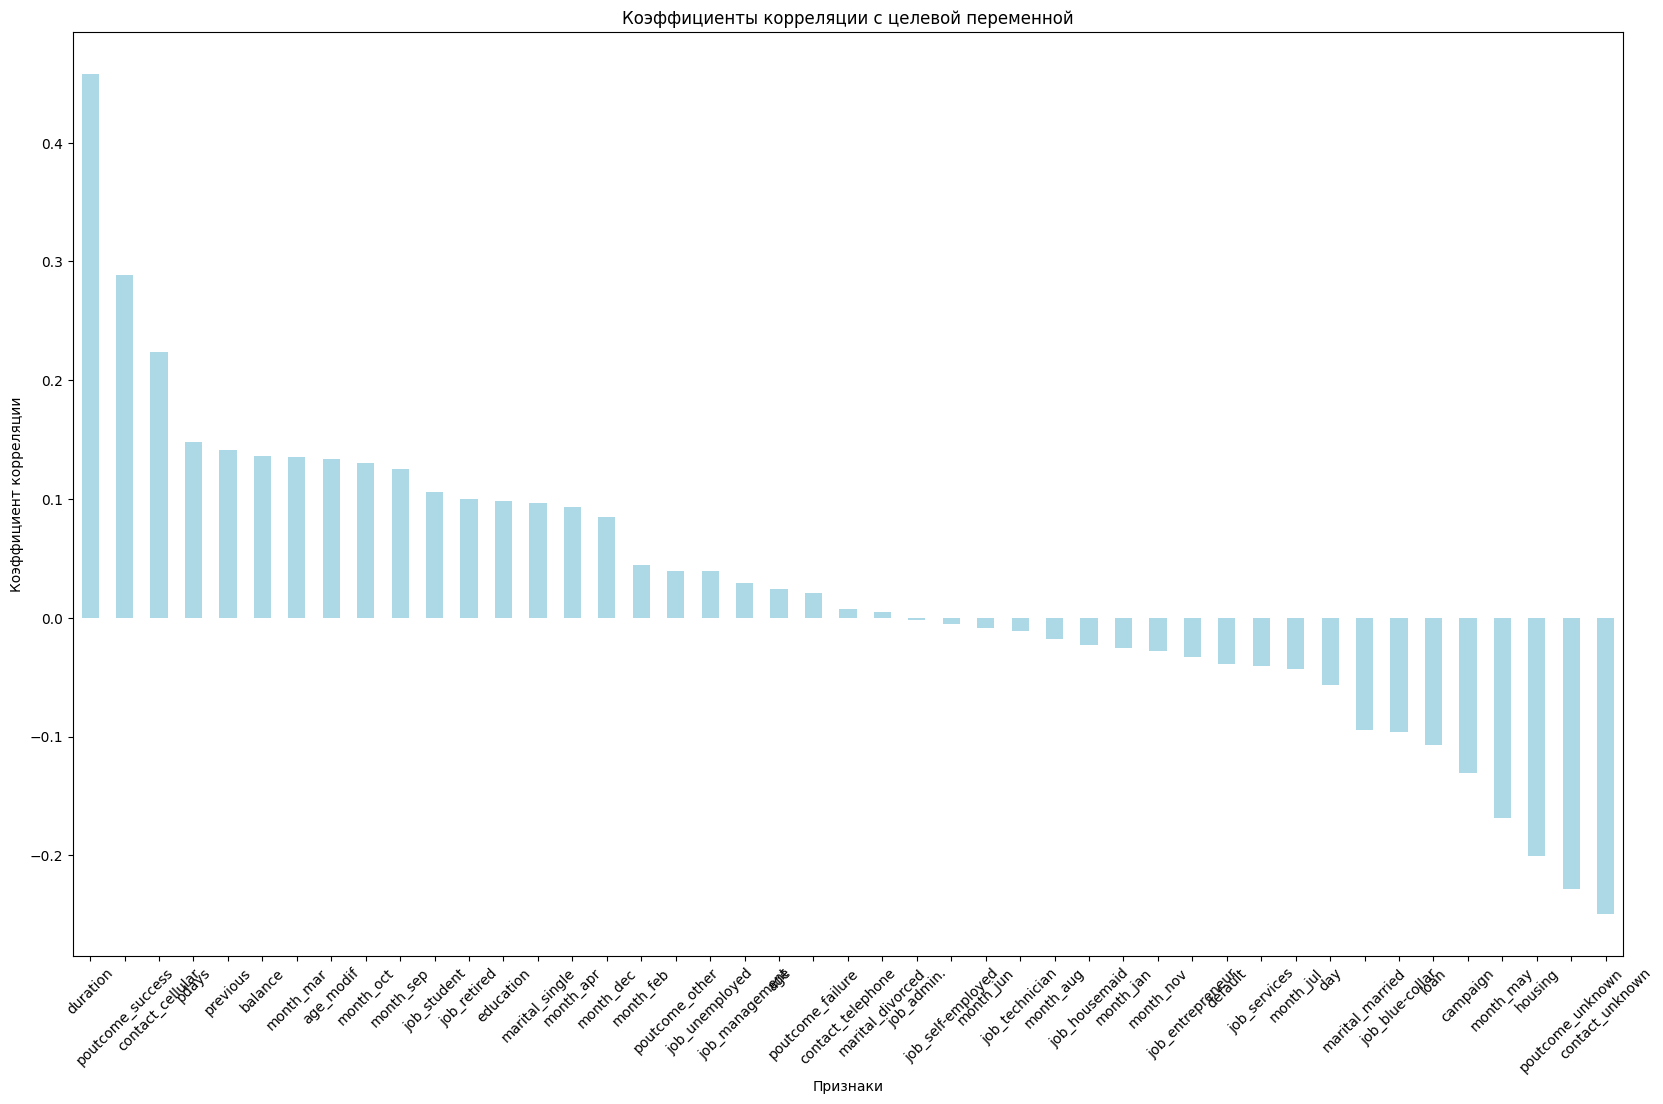

In [53]:
# Получаем коэффициенты корреляции с целевой переменной
target_corr = corr['deposit'].drop('deposit').sort_values(ascending=False)

# Столбчатая диаграмма для ранжированных коэффициентов корреляции
plt.figure(figsize=(20, 12))
target_corr.plot(kind='bar', color='lightblue')
plt.title('Коэффициенты корреляции с целевой переменной')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент корреляции')
plt.xticks(rotation=45)
plt.show()

Мы видим из диаграммы, что ни удного из признаков нет связи выше умеренной (коэффициент корелляции $> 0.5%$). Только признак **duration** (продолжительность контакта в секундах) имеет умеренную связь с целевым признаком **deposit** (коэффициент корелляции $> 0.45%$).

### Задания 7 и 8

Теперь нам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении зададим параметр random_state = 42, а размер тестовой выборки возьмем за 0.33.

In [54]:
X = df_4.drop(['deposit'], axis=1)
y = df_4['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [55]:
# Размер тестовой выборки

X_test.shape

(3335, 44)

In [56]:
# Среднее значение целевой переменной на тестовой выборке.

print(round(y_test.mean(),2))

0.46


### Задание 9

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр score_func = f_classif.

In [57]:
# Выбираем только числовые признаки
numerical_features = df_4.select_dtypes(include=['int64', 'float64', 'bool']).columns

# Применяем SelectKBest для выбора 15 лучших признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_new = selector.fit_transform(X_train, y_train)

# Получаем маску выбранных признаков
selected_features_mask = selector.get_support()

# Получаем имена отобранных признаков
selected_features = X_train.columns[selected_features_mask]

# Выводим имена выбранных признаков
print("Выбранные признаки:\n", selected_features)

Выбранные признаки:
 Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_modif', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [58]:
# Оставим среди предикторов - признаки отобранные методом SelectKBest
X = df_4[selected_features]

X

,balance,housing,duration,campaign,pdays,previous,age_modif,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,2343.0,1,1042,1,-1,0,2,False,True,False,True,False,False,False,True
1,45.0,0,1467,1,-1,0,2,False,True,False,True,False,False,False,True
2,1270.0,1,1389,1,-1,0,1,False,True,False,True,False,False,False,True
3,2476.0,1,579,1,-1,0,2,False,True,False,True,False,False,False,True
4,184.0,0,673,2,-1,0,2,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1.0,1,257,1,-1,0,0,True,False,False,False,False,False,False,True
11158,733.0,0,83,4,-1,0,0,False,True,False,False,False,False,False,True
11159,29.0,0,156,2,-1,0,0,True,False,False,False,False,False,False,True
11160,0.0,0,9,2,172,5,1,True,False,False,True,False,False,False,False


### Задание 10

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

Нормализация требуется для предикторов, а не для целевой переменной.

Нормализируем предикторы в обучающей и тестовой выборках.

In [59]:
# Повторим разбиение с учетом отобранных 15 признаков - предикторов.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [60]:
from sklearn.preprocessing import MinMaxScaler

# Создаем объект MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем обучающую выборку
X_train_normalized = scaler.fit_transform(X_train)

# Нормализуем тестовую выборку, используя параметры, полученные из обучающей выборки
X_test_normalized = scaler.transform(X_test)

# Преобразуем массивы обратно в DataFrame
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Выводим нормализованные данные

X_train_normalized.head()

,balance,housing,duration,campaign,pdays,previous,age_modif,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,0.426374,1.0,0.131735,0.00000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.346531,0.0,0.075793,0.00000,0.240936,0.034483,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.335242,1.0,0.102346,0.02381,0.419883,0.086207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.407886,0.0,0.034803,0.00000,0.120468,0.086207,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.571499,0.0,0.025264,0.00000,0.138012,0.137931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
# Получим среднее значение первого признака в тестовой выборке
print(round(X_test_normalized.iloc[:, 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оценим качество модели на тестовой выборке.

Для получившейся модели вычислим значение accuracy на тестовой выборке.

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Примените Logistic Regression
model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Обучение модели
model.fit(X_train_normalized, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_normalized)

# Вычисление accuracy на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)

print(f"Значение accuracy на тестовой выборке: {round(accuracy,2)}")

Значение accuracy на тестовой выборке: 0.81


Т.к. значения датасета по целевому признаку достаточно сбалансированы, то метрику accuracy можно использовать для оценки качества модели. 0.81 давольно приемлемая метрика. Мы попробуем применить другие модели к нашему датасету и посмотрим, что получится.

### Задания 2,3,4

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

- criterion = 'entropy';
- random_state = 42.
  
Остальные параметры оставьте по умолчанию.

In [71]:
from sklearn.tree import DecisionTreeClassifier

# Создаем модель решающего дерева
tree_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучаем модель
tree_model.fit(X_train_normalized, y_train)

# Предсказание на тестовой выборке
y_pred_tree = tree_model.predict(X_test_normalized)

# Вычисление accuracy на тестовой выборке
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(f"Значение accuracy на тестовой выборке: {round(accuracy_tree,2)}")

Значение accuracy на тестовой выборке: 0.75


Мы имеем показатель метрики довольно низкий - значит наша модель "переобучилась" на тренировочных данных. Попробуем "в ручную" в цикле подобрать показатель максимальной глубины дерева и выбрать ту глубину при которой наша метрика будет максимальной.

In [72]:
# Мы создали список с двумя записями для поиска максимальной метрики при глубине дерева
# По умолчанию взяли результат предідущей модели при неограниченной глубине дерева.
MAX_accuracy_tree = (accuracy_tree, 0)

# Делаем в цикле перебор моделей с показателем глубины дерева от 1 до 10
# Обучаем каждую модель и смотрим значение метрики accuracy - выбираем модель с максимальной метрикой и фиксируем глубину дерева в нашей модели
for i in range (1,10):
    tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=42)
    tree_model.fit(X_train_normalized, y_train)
    y_pred_tree = tree_model.predict(X_test_normalized)
    accuracy_tree_ = round(accuracy_score(y_test, y_pred_tree),2)
    if accuracy_tree_ > MAX_accuracy_tree[0]:
        MAX_accuracy_tree = (accuracy_tree_, i)
        
print(MAX_accuracy_tree)

(0.81, 6)


При переборе моделей с алгоритмом "решающее дерево" у нас наилучшую метрику **accuracy** - 0.81 при показателе глубина дерева **max_depth** - 6.

### Задание 5

Переберем различные максимальные глубины деревьев и найдем глубину дерева, для которой будет максимальное значение метрики **accuracy**, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой). Используем **Gridsearch**.

In [74]:
from sklearn.model_selection import GridSearchCV

# Создаем объект решающего дерева
tree_model_ = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Определяем диапазон значений для максимальной глубины
param_grid = {'max_depth': list(range(1, 10))}  # Перебираем глубины от 1 до 10

# Определяем GridSearchCV с 5-фолдовой кросс-валидацией
grid_search = GridSearchCV(estimator=tree_model_, param_grid=param_grid, 
                           scoring='accuracy', cv=5, return_train_score=True)

# Обучаем модель
grid_search.fit(X_train_normalized, y_train)

# Извлекаем результаты из GridSearchCV
results = grid_search.cv_results_

# Создаем DataFrame для удобного отображения результатов
results_df = pd.DataFrame(results)

# Получаем лучшее значение max_depth и соответствующее значение accuracy
best_index = results_df['rank_test_score'][0] - 1  # Индекс для лучшего результата
best_max_depth = results_df.loc[best_index, 'param_max_depth']
best_train_accuracy = results_df.loc[best_index, 'mean_train_score']
best_test_accuracy = results_df.loc[best_index, 'mean_test_score']

# Выводим лучший параметр и соответствующие значения accuracy
print(f"Лучшая глубина дерева: {best_max_depth}")
print(f"Accuracy на обучающей выборке: {round(best_train_accuracy, 4)}")
print(f"Accuracy на тестовой выборке: {round(best_test_accuracy, 4)}")

# Фильтрация результатов для выявления переобучения
filtered_results = results_df[results_df['mean_train_score'] > best_train_accuracy - 0.01]

# Извлекаем глубины, у которых не наблюдается переобучения
non_overfitting_depths = filtered_results[filtered_results['mean_test_score'] >= best_test_accuracy]

print("\nГлубины, при которых не наблюдается переобучение:")
print(non_overfitting_depths[['param_max_depth', 'mean_train_score', 'mean_test_score']])

Лучшая глубина дерева: 9
Accuracy на обучающей выборке: 0.8574
Accuracy на тестовой выборке: 0.8173

Глубины, при которых не наблюдается переобучение:
   param_max_depth  mean_train_score  mean_test_score
8                9          0.857386         0.817282


Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

- 'min_samples_split': [2, 5, 7, 10];
- 'max_depth':[3,5,7].

In [77]:
# Создаем объект решающего дерева
tree_model = DecisionTreeClassifier(random_state=42)

# Определяем параметры для перебора
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Определяем GridSearchCV с 5-фолдовой кросс-валидацией
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, 
                           scoring='f1', cv=5, return_train_score=True)

# Обучаем модель
grid_search.fit(X_train_normalized, y_train)

# Извлекаем результаты из GridSearchCV
results = grid_search.cv_results_

# Создаем DataFrame для удобного отображения результатов
results_df = pd.DataFrame(results)

# Получаем информацию о лучшей комбинации параметров
best_index = results_df['rank_test_score'][0] - 1  # Индекс для лучшего результата
best_params = results_df.loc[best_index, ['params', 'mean_test_score', 'mean_train_score']]

# Выводим лучшие параметры и соответствующее значение accuracy
print("Лучшие параметры:", best_params['params'])
print("F1 на тестовой выборке:", round(best_params['mean_test_score'], 4))
print("F1 на обучающей выборке:", round(best_params['mean_train_score'], 4))

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 2}
F1 на тестовой выборке: 0.7993
F1 на обучающей выборке: 0.8284


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучим случайный лес со следующими параметрами:

- n_estimators = 100;
- criterion = 'gini';
- min_samples_leaf = 5;
- max_depth = 10;
- random_state = 42.

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Создаем модель случайного леса с заданными параметрами
rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

# Обучаем модель
rf_model.fit(X_train_normalized, y_train)

# Предсказание на тестовой выборке
y_pred_rf = rf_model.predict(X_test_normalized)

Оценим метрики accuracy и recall для построенной модели на тестовой выборке. В качестве ответов введем значения метрик.

In [79]:
from sklearn.metrics import recall_score

# Вычисление accuracy на тестовой выборке
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Вычисление recall на тестовой выборке
recall_rf = recall_score(y_test, y_pred_rf)


# Выводим результат
print(f"Значение accuracy для случайного леса на тестовой выборке: {round(accuracy_rf,2)}")

print(f"Значение recall для случайного леса на тестовой выборке: {round(recall_rf,2)}")

Значение accuracy для случайного леса на тестовой выборке: 0.83
Значение recall для случайного леса на тестовой выборке: 0.83


In [82]:
# Вычисление F1 на тестовой выборке
f1_rf = f1_score(y_test, y_pred_rf)


# Выводим результат
print(f"Значение F1 для случайного леса на тестовой выборке: {round(f1_rf,2)}")

Значение F1 для случайного леса на тестовой выборке: 0.82


### Задания 2 и 3

Сравним полученные результаты с моделью градиентного бустинга. Используем градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

- learning_rate = 0.05;
- n_estimators = 300;
- min_samples_leaf = 5;
- max_depth = 5;
- random_state = 42.

Для построенной модели оценим метрику $F1$ на тестовой выборке.

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Создаем модель градиентного бустинга с заданными параметрами
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Обучаем модель
gb_model.fit(X_train_normalized, y_train)

# Предсказание на тестовой выборке
y_pred_gb = gb_model.predict(X_test_normalized)

# Вычисление метрики F1 на тестовой выборке
f1 = f1_score(y_test, y_pred_gb)

print(f"Значение F1 для градиентного бустинга на тестовой выборке: {round(f1,2)}")

Значение F1 для градиентного бустинга на тестовой выборке: 0.82


In [81]:
# Вычисление accuracy на тестовой выборке
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Вычисление recall на тестовой выборке
recall_gb = recall_score(y_test, y_pred_gb)

print(f"Значение accuracy для градиентного бустинга на тестовой выборке: {round(accuracy_gb,2)}")

print(f"Значение recall для градиентного бустинга на тестовой выборке: {round(recall_gb,2)}")

Значение accuracy для градиентного бустинга на тестовой выборке: 0.83
Значение recall для градиентного бустинга на тестовой выборке: 0.83


В моем случае эффективность моделей Случайного Леса и Градиентного бустинга одинакова. При прочих равных условиях модель Случайного Леса выглядит более предпочтительной, т.к. требует меньше вычислений - у менчя на машине время вычислений алгоритма Случайного Леса - 0,3 секунды, а при Градиентном бустинге - 2,4 секунды - в 8 раз дольше.

### Задание 4

Мы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

Попробуем использовать стекинг, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставим те же, что были в ваших алгоритмах в предыдущих заданиях.

In [92]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import precision_score

# Базовые модели
dt = DecisionTreeClassifier(max_depth=7, min_samples_split=2, random_state=42)

lr = LogisticRegression(solver='sag', random_state=42, max_iter=1000)


gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Метамодель
meta_model = LogisticRegression(C=1.0, random_state=42)

# Создание ансамбля
estimators = [
    ('dt', dt),
    ('lr', lr),
    ('gb', gb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)

clf.fit(X_train_normalized, y_train)

y_pred_clf = clf.predict(X_test_normalized)

precision_clf = precision_score(y_test, y_pred_clf)

print(f"Значение precision для стейкинга на тестовой выборке: {round(precision_clf,2)}")


Значение precision для стейкинга на тестовой выборке: 0.81


### Задание 5

Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

In [93]:
# Получение важности признаков
feature_importances = gb_model.feature_importances_

# Создание DataFrame с названиями признаков и их важностью
feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Сортировка DataFrame по важности признаков
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Вывод 5 наиболее важных признаков
print(feature_importances_df.head())

             feature  importance
2           duration    0.507106
13  poutcome_success    0.114958
8    contact_unknown    0.072582
0            balance    0.057952
4              pdays    0.055121


По важности были выделены следующие пять признаков:
1. **duration** - продолжительность контакта в секундах - чем больше мы общаемся с клиентами - тем больше вероятность успеха нашей рекламной компании;
2. **poutcome_success** - если прошлая рекламная компания дала положительный результат с клиентом - тем больше вероятность при повторном общении убедить клиента продолжать оставаться нашим вкладчиком;
3. **contact_unknown** - клиенты с которыми мы контактировали, но каким образом в базе не указано оказывается имеют важность больше чем клиенты с которыми мы общались по телефону или по сотовому;
4. **balance** - размер остатка на счете клиента влияет на его решение разместить депозит в банке.
5. **pdays** - количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании имеет важность в принятии решения.

Вывод - от качества проведенной рекламной компании сильно зависсит ее успешность. Маркетологи должны проработать базу клиентов и по возможности их всех обзвонить и пообщаться с ними не минуту-две, а проовести качественную беседу.

### Задания 6,7,8

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Применим его для оптимизации гиперпараметров. Для перебора возьмем случайный лес и следующие параметры:

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
max_depth = trial.suggest_int('max_depth', 10, 30, 1);
min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

Посмотрим значение метрики $F1$ и $accuracy$ на тестовой выборке.

In [94]:
import optuna

def objective(trial):
    # Определяем гиперпараметры, которые будем оптимизировать
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель случайного леса с заданными гиперпараметрами
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               random_state=42)
    
    # Обучаем модель на тренировочных данных
    rf.fit(X_train_normalized, y_train)
    
    # Делаем предсказания на тестовой выборке и вычисляем accuracy
    y_pred = rf.predict(X_test_normalized)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    #f1 = f1_score(y_test, y_pred)
    
    return accuracy#, f1


# Инициализация Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_normalized, y_train)

y_pred_optuna1 = best_model.predict(X_test_normalized)

best_accuracy = accuracy_score(y_test, y_pred_optuna1)

print(f"Лучшее значение accuracy для OPTUNA на тестовой выборке: {round(best_accuracy,2)}")

[I 2024-10-04 23:10:32,469] A new study created in memory with name: no-name-21b8b553-19cf-4b87-b578-352e7d05be2d
[I 2024-10-04 23:10:33,190] Trial 0 finished with value: 0.8278860569715143 and parameters: {'n_estimators': 197, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8278860569715143.
[I 2024-10-04 23:10:33,650] Trial 1 finished with value: 0.8239880059970015 and parameters: {'n_estimators': 153, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8278860569715143.
[I 2024-10-04 23:10:34,185] Trial 2 finished with value: 0.8263868065967016 and parameters: {'n_estimators': 167, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8278860569715143.
[I 2024-10-04 23:10:34,880] Trial 3 finished with value: 0.8296851574212893 and parameters: {'n_estimators': 197, 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8296851574212893.
[I 2024-10-04 23:10:35,486] Trial 4 finished with value: 0.825487256371814

Лучшее значение accuracy для OPTUNA на тестовой выборке: 0.83


In [95]:
import optuna

def objective(trial):
    # Определяем гиперпараметры, которые будем оптимизировать
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель случайного леса с заданными гиперпараметрами
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               random_state=42)
    
    # Обучаем модель на тренировочных данных
    rf.fit(X_train_normalized, y_train)
    
    # Делаем предсказания на тестовой выборке и вычисляем accuracy
    y_pred = rf.predict(X_test_normalized)
    
    f1 = f1_score(y_test, y_pred)
    
    return f1


# Инициализация Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_normalized, y_train)

y_pred_optuna2 = best_model.predict(X_test_normalized)

best_f1 = accuracy_score(y_test, y_pred_optuna2)

print(f"Лучшее значение F1 для OPTUNA на тестовой выборке: {round(best_f1,2)}")

[I 2024-10-04 23:12:01,315] A new study created in memory with name: no-name-4ea825bd-e729-4fba-9a98-3469c40070d8
[I 2024-10-04 23:12:01,863] Trial 0 finished with value: 0.8203026481715007 and parameters: {'n_estimators': 158, 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8203026481715007.
[I 2024-10-04 23:12:02,450] Trial 1 finished with value: 0.8166877370417194 and parameters: {'n_estimators': 159, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8203026481715007.
[I 2024-10-04 23:12:02,981] Trial 2 finished with value: 0.8192695214105793 and parameters: {'n_estimators': 146, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8203026481715007.
[I 2024-10-04 23:12:03,336] Trial 3 finished with value: 0.8170886075949367 and parameters: {'n_estimators': 114, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8203026481715007.
[I 2024-10-04 23:12:03,897] Trial 4 finished with value: 0.816571790006325

Лучшее значение F1 для OPTUNA на тестовой выборке: 0.83


Алгоритм OPTUNA дал результат лучше чем алгоритм Стейкинга.

## **Вывод:**

Мы провели предварительный анализ нашего датафрейма. Обработали признаки, в том числе создавая новые из первоначально данных нам, привели признаки их главным образом к цифрофому типу в т.ч. создавая dummy-переменных, через SelectKBest выделели 15 наиболее важных признаков, затем мы эти признаки нормализовали используя метод MinMaxScaler.

Наш  целевой признак 'deposit' - бинарный (0 или 1) - мы решали задачу классификации - относится ли клиент к группе 0 или группе 1. Наш целевой признак был сбалансирован в базе и нам не пришлось использовать балансировщик.

Мы сначала построили самую простую модель логистической регрессии и получили довольно высокую метрику accuracy.

Далее построили модель Решающих Деревьев - сначала с параметрами по умолчанию, затем циклом подбирали глубину дерева для наших моделей и отобрали модель с наилучшей метрикой. Подбор гиперпараметров попробовали сделать также методом Gridsearch. Нам нужно было решить проблему переобучения модели (метрики на тестовой и тренировочной выборках должны по возможности совпадать или отличаться на минимальный процент)

Построили также модели случайного леса, градиентного бустинга и посмотрели как меняются метрики.

Далее применили методы ансамбля моделей - Стейкинг и OPTUNA.

На мой взгляд предпочтительнее пользоватьс моделью Случайного Леса, т.к. она дает те же метрики, что более сложные алгоритмы - Градиентного Бустинга и Ансамбли моделей (Стейкинг и OPTUNA), но требует меньше вычислений, что будет важно при дальнейшем маштабировании нашей моделей. Из Ансамблей моделей льучше себя показала модель OPTUNA.
